In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import glob #파일들의 리스트를 뽑을 때 사용
from scipy.spatial import distance
from sklearn.model_selection import train_test_split #train, test 데이터 분할
from sklearn.metrics import classification_report, confusion_matrix
#class.report : 분류한 결과를 평가? , conf.matrix : 분류결과표(원래의 클래스와 예측한 클래스가 얼마나 일치하는지를 구분)
import tensorflow as tf
from tensorflow.keras import Sequential, models
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
path = "data/input/face-mask-12k-images-dataset/Face Mask Dataset/"

dataset = {
    "image_path" : [],
    "mask_status" : [],
    "where" : []
}

for where in os.listdir(path): #os.listdir : 해당 디렉토리에 있는 파일들의 리스트 구하기
    for status in os.listdir(path+ "/" + where) : 
        for image in glob.glob(path + where + "/" + status + "/" + "*.png"): #glob : 동일 패턴와 이름이 일치하는 모든 파일 부르기
            dataset["image_path"].append(image)
            dataset["mask_status"].append(status)
            dataset["where"].append(where)

dataset = pd.DataFrame(dataset)
dataset.head() # 상위 n개의 행 출력



,image_path,mask_status,where
0,data/input/face-mask-12k-images-dataset/Face M...,WithMask,Test
1,data/input/face-mask-12k-images-dataset/Face M...,WithMask,Test
2,data/input/face-mask-12k-images-dataset/Face M...,WithMask,Test
3,data/input/face-mask-12k-images-dataset/Face M...,WithMask,Test
4,data/input/face-mask-12k-images-dataset/Face M...,WithMask,Test


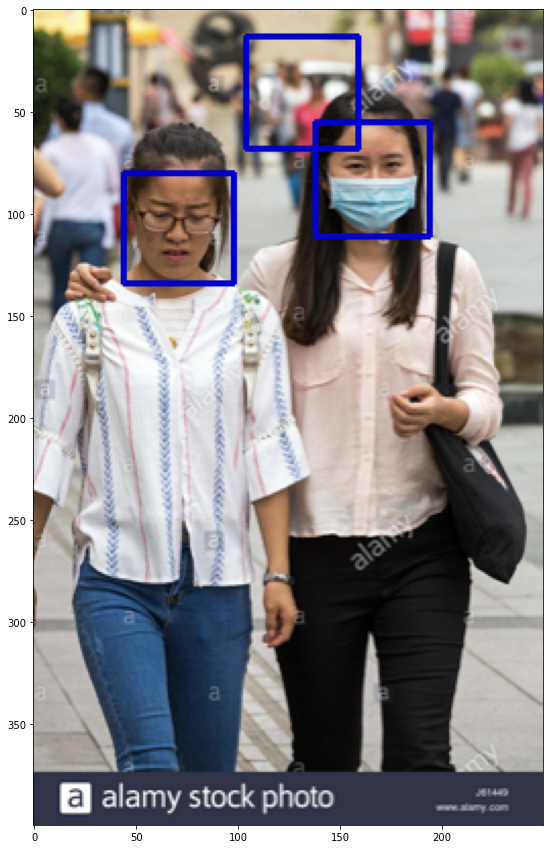

In [11]:
face_mode1 = cv2.CascadeClassifier('data/input/haarcascades/haarcascade_frontalface_default.xml')
# HAAR CASCADE : 얼굴을 찾는 방법
img = cv2.imread("data/input/face-mask-detection/images/maksssksksss352.png")

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

detected_face = face_mode1.detectMultiScale(img) # detectMultiScale : gray img를 이용하여 얼굴 검출

output_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# (x,y) : 사각형의 시작좌표(왼쪽 아래), (x + w, y + h): 사각형의 끝좌표(오른쪽 위)
for (x, y, w, h) in detected_face: 
    cv2.rectangle(output_img, (x, y), (x + w, y + h), (0, 0, 200), 2)
# 위 함수로 얼굴로 보이는 부분에 사각형 표시
plt.figure(figsize = (15, 15))
plt.imshow(output_img)

In [ ]:
if len(detected_face) >= 2: # 보이는 얼굴이 2 이상인가?
    label = [0 for i in range(len(detected_face))]
    #한 이미지에서 다른 이미지까지의 거리 
    for i in range(len(detected_face) - 1):  
        for j in range(i + 1, len(detected_face)): #[:2] x, y 값만 계산
            dist = distance.euclidean(detected_face[i][:2], detected_face[j][:2]) # distance.euclidean : 유클리드 거리 (최소 거리)

            if dist < 130: #6피트보다 거리가 가까운가?
                label[i] = 1
                label[j] = 1
    
    new_image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    for i in range(len(detected_face)):
        (x, y, w, h) = detected_face[i]
        if label[i] == 1:
            cv2.rectangle(new_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    plt.figure(figsize = (10, 10))  
    plt.imshow(new_image)

In [ ]:
print(f"With mask:", dataset.value_counts("mask_status")[0])
print(f"Without Mask:", dataset.value_counts("mask_status")[1])

sns.countplot(x = dataset["mask_status"])

In [ ]:
plt.figure(figsize = (15, 10))

for i in range(9):
    random = np.random.randint(1, len(dataset)) # 랜덤하게 선택
    plt.subplot(3, 3, i + 1) # 3 by 3 으로 나타내기
    plt.imshow(cv2.imread(dataset.loc[random, "image_path"])) # 랜덤으로 이미지를 보여주기
    plt.title(dataset.loc[random, "mask_status"], size = 15) # 랜덤 이미지에 마스크유무 판단
    plt.xticks([])
    plt.yticks([])

plt.show()

In [ ]:
train_df = dataset[dataset["where"] == "Train"]
test_df = dataset[dataset["where"] == "Test"]
valid_df = dataset[dataset["where"] == "Validation"]

print(train_df.head(10))
# sample : 표본추출(frac = 1일 경우 전부 추출)
train_df = train_df.sample(frac = 1)
test_df = test_df.sample(frac = 1)
valid_df = valid_df.sample(frac = 1)

print("\n After Shuffling \n")
print(train_df.head(10))

In [ ]:
plt.figure(figsize = (15, 15))
plt.subplot(1, 3, 1)
sns.countplot(x = train_df["mask_status"])
plt.title("Training Dataset", size = 10)
#sns.countplot : 데이터 시각화(차트 그리기), x = ?일 경우 세로 그래프
plt.subplot(1, 3, 2)
sns.countplot(x = train_df["mask_status"])
plt.title("Test Dataset", size = 10)

plt.subplot(1, 3, 3)
sns.countplot(x = train_df["mask_status"])
plt.title("Validation Dataset", size = 10)

plt.show()

In [ ]:
train_df = train_df.reset_index().drop("index", axis = 1) #reset.index() : 인덱스를 처음부터 재배열, drop() : 괄호 안을 제외한 새로운 객체 생성
train_df.head()

data = []
image_size = 150

for i in range(len(train_df)):
    img_gray = cv2.imread(train_df["image_path"][i], cv2.IMREAD_GRAYSCALE)
    new_image_gray = cv2.resize(img_array, (image_size, image_size))

    if train_df["mask-status"][i] == "WithMask":
        data.append([new_image_array, 1])
    else:
        data.append([new_image_array, 0])

In [ ]:
data = np.array(data)

In [ ]:
data[0][0].shape

In [ ]:
np.random.shuffle(data)